<a href="https://colab.research.google.com/github/Eslam-elnahas/My-Project-/blob/main/App_Code_Predection_Base_Gradio_UI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U segmentation-models


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.9 MB/s eta 0:00:00


In [2]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.3 MB/s eta 0:00:00


In [3]:
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import random
import gradio as gr

In [4]:
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [5]:
from keras import backend as K

In [6]:
from keras.models import load_model

In [7]:
def Jaccard_coef(y_true,y_pred):
  y_true_flatten=K.flatten(y_true)
  y_pred_flatten=K.flatten(y_pred)
  intersection=K.sum(y_true_flatten*y_pred_flatten)
  final_coef_value=(intersection + 1.0 )/ (K.sum (y_true_flatten) + K.sum (y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [8]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)




In [10]:
satellite_model = load_model('/content/satellite_segmentation_full.h5',
                          custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                           'Jaccard_coef': Jaccard_coef})

In [11]:
# satellite_model.get_config()


In [35]:
image = Image.open('/content/F_1.jpg')
image = image.resize((256,256))
image = image.convert('RGB')
image = np.array(image)
image = np.expand_dims(image, 0)

In [36]:
prediction = satellite_model.predict(image)


1/1 [==============================] - 0s 59ms/step


In [32]:

predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

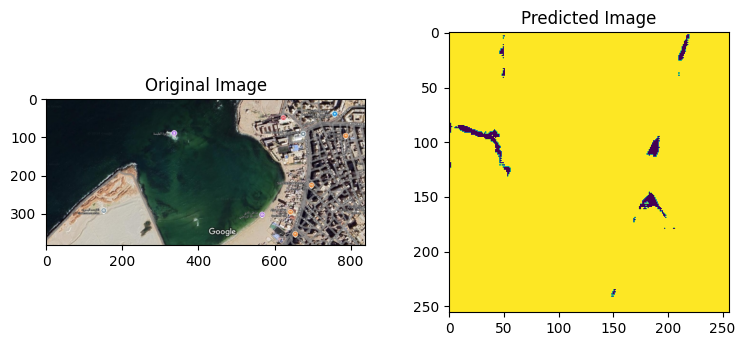

In [37]:

plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(Image.open('/content/F_1.jpg'))
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)

In [49]:
def process_input_image(image_source):
  image = image_source
  image = Image.fromarray(image_source)
  image = image.resize((256,256))      # يستخدم هذا الكود لتحويل حجم الصورة الي 256 * 256 اولا قبل البد وعند تحميل الصورة في واجهه المستخدم  ا
  image = image.convert('RGB')
  image = np.array(image)
  image = np.expand_dims(image_source, 0)

  prediction = satellite_model.predict(image)
  predicted_image = np.argmax(prediction, axis=3)

  predicted_image = predicted_image[0,:,:]
  predicted_image = predicted_image * 50
  print(predicted_image)
  return 'Predicted Masked Image', predicted_image

In [50]:
my_app=gr.Blocks()

In [51]:
with my_app:
  gr.Markdown("Statellite Image Segmentation Application UI with Gradio")
  with gr.Tabs():
    with gr.TabItem("Select your image"):
      with gr.Row():
        with gr.Column():
            img_source = gr.Image(label="Please select source Image")#, width=256, height=256)
            source_image_loader = gr.Button("Load above Image")
        with gr.Column():
            output_label = gr.Label(label="Image Info")
            img_output = gr.Image(label="Image Output")
    source_image_loader.click(
        process_input_image,
        [
            img_source
        ],
        [
            output_label,
            img_output
        ]
    )

In [ ]:
my_app.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://c19179c886d3846e8f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 252ms/step
[[150 150 150 ... 150 150 150]
 [150 150 150 ... 150 150 150]
 [150 150 150 ... 150 150 150]
 ...
 [150 150 150 ... 150 150 150]
 [150 150 150 ... 150 150 150]
 [150 150 150 ... 150 150 150]]


In [46]:
my_app.close()


Closing server running on port: 7860
